In [9]:
import os
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date


DOWNLOAD_ROOT = "https://raw.githubusercontent.com/pcm-dpc/COVID-19"
COVID_PATH = os.path.join("datasets", "covid")
COVID_REGIONI_URL = DOWNLOAD_ROOT + "/master/dati-regioni/dpc-covid19-ita-regioni.csv"
COVID_PROVINCE_URL = DOWNLOAD_ROOT + "/master/dati-province/dpc-covid19-ita-province.csv"
COVID_NAZIONE_URL = DOWNLOAD_ROOT + "/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
url_dict={'regioni.csv':COVID_REGIONI_URL,'province.csv':COVID_PROVINCE_URL,'nazione.csv':COVID_NAZIONE_URL}
def fetch_dati(url,file,path=COVID_PATH):
    os.makedirs(path, exist_ok=True)
    newpath=os.path.join(path, file)
    urllib.request.urlretrieve(url, newpath)
def load_dati(file,path=COVID_PATH):
    csv_path=os.path.join(path, file)
    return pd.read_csv(csv_path)

fetch_dati(COVID_REGIONI_URL,file='regioni.csv')
regioni=load_dati('regioni.csv')
fetch_dati(COVID_PROVINCE_URL,file='province.csv')
province=load_dati('province.csv')
fetch_dati(COVID_NAZIONE_URL,file='nazione.csv')
nazione=load_dati('nazione.csv')

Some data is useless, and is now removed

In [10]:
#regioni
day=regioni.data.copy()
day=np.array(day)
for i in range(len(day)):
    day[i]=day[i][5:10]
    #Per estrarre mese e giorno prendiamo i caratteri dal 5 al 9 inclusi della feature "data"
regioni.insert(0,column='day', value=day)

#province
day=province.data.copy()
day=np.array(day)
for i in range(len(day)):
    day[i]=day[i][5:10]
province.insert(0,column='day', value=day)

#nazione
day=nazione.data.copy()
day=np.array(day)
for i in range(len(day)):
    day[i]=day[i][5:10]
nazione.insert(0,column='day', value=day)

In [11]:
province

,day,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi,note_it,note_en
0,02-24,2020-02-24T18:00:00,ITA,13,Abruzzo,69,Chieti,CH,42.351032,14.167546,0,NaN,NaN
1,02-24,2020-02-24T18:00:00,ITA,13,Abruzzo,66,L'Aquila,AQ,42.351222,13.398438,0,NaN,NaN
2,02-24,2020-02-24T18:00:00,ITA,13,Abruzzo,68,Pescara,PE,42.464584,14.213648,0,NaN,NaN
3,02-24,2020-02-24T18:00:00,ITA,13,Abruzzo,67,Teramo,TE,42.658918,13.704400,0,NaN,NaN
4,02-24,2020-02-24T18:00:00,ITA,13,Abruzzo,979,In fase di definizione/aggiornamento,NaN,0.000000,0.000000,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4475,03-29,2020-03-29T17:00:00,ITA,5,Veneto,26,Treviso,TV,45.667546,12.245074,1402,NaN,NaN
4476,03-29,2020-03-29T17:00:00,ITA,5,Veneto,27,Venezia,VE,45.434905,12.338452,1067,NaN,NaN
4477,03-29,2020-03-29T17:00:00,ITA,5,Veneto,23,Verona,VR,45.438390,10.993527,1876,NaN,NaN
4478,03-29,2020-03-29T17:00:00,ITA,5,Veneto,24,Vicenza,VI,45.547497,11.545971,1104,NaN,NaN


then we drop the 'data' & 'stato' column which are now useless

In [12]:
def combine_to_dict(df,upto,f1,f2):
    d12={}
    d21={}
    for i in range(upto):
        one=df.at[i,f1]
        two=df.at[i,f2]
        d12[one]=two
        d21[two]=one
    return d12,d21
reg_num_as_key,reg_name_as_key=combine_to_dict(regioni,20,f1='codice_regione',f2='denominazione_regione')
prov_num_as_key,prov_name_as_key=combine_to_dict(province,128,f1='codice_provincia',f2='denominazione_provincia')
#Per inciso, quello delle prov ha qualcosa che non va


#Queeste righe bastano per le regioni
reg_codes=pd.DataFrame(data=regioni, columns=["denominazione_regione", "codice_regione"])
num=len(reg_codes)-21
reg_codes.drop(reg_codes.tail(num).index, inplace=True)
#Province è un po'infame, ha bassa priorità ma magari lo farò

now we try to create a dataframe/dictionary which combines values of codice_regione with values of denominazione_regione

we know there are 20 regions so it is enough to access the data frame up to the 20th row. 

In [13]:
regioni=regioni.drop(['data','stato', 'codice_regione', 'note_it', 'note_en'],axis=1, errors="ignore")
province=province.drop(['data','stato','codice_regione', 'codice_provincia', 'note_it', 'note_en'],axis=1, errors="ignore")
nazione=nazione.drop(['data','stato', 'note_it', 'note_en'],axis=1, errors="ignore")

now we will shorten the dataframe so that we store in another dataframe the longitude and latitude coordinates which do not change at all

In [14]:
def combine_to_datfr(df,row,col,upto):
    ind=[row[i] for i in range(upto)]
    dt=[]
    for i in range(upto):
        d=[]
        for feat in col:
            el=df.at[i,feat]
            d.append(el)
        dt.append(d)
    ret=pd.DataFrame(data=dt,index=ind,columns=col)
    return ret
def create_geo_loc(df):
    geo_loc=regioni.denominazione_regione.copy()
    geo_loc=pd.DataFrame(data=geo_loc)
    geo_loc["lat"]=regioni.lat.copy()
    geo_loc["long"]=regioni.long.copy()
    num=len(geo_loc)-21
    geo_loc.drop(geo_loc.tail(num).index,inplace=True)
    return geo_loc


def create_geo_loc_2(df):
    if "denominazione_provincia" in df.columns:
        denom="denominazione_provincia"
        cont=80
    else:
        denom="denominazione_regione"
        cont=21
    geo_loc=pd.DataFrame(data=df,columns=[denom, "lat", "long"])
    #geo_loc.drop(geo_loc.loc[geo_loc['lat'] == 0])
    num=len(geo_loc)-cont
    geo_loc.drop(geo_loc.tail(num).index,inplace=True)
    return geo_loc

#TODO: Sceglierne una (io voto per create_geo_loc_2  :) )


new=combine_to_datfr(regioni,regioni.denominazione_regione,['lat','long'],21)
#new=combine_to_datfr(province,province.denominazione_provincia,['lat','long'],80)
#Anche qua province ha qualche problema, suppongo per problema intrinseco al dataset

#nemmeno il mio funziona con le province al momento

new=create_geo_loc_2(province)

#new


# A first analysis

as we can see, we have each day a number of measurements for 21 regions (numbered from 1 to 20)

we can simply extract the number of observations of the civil protection by dividing the shape of the dataframe by 21

In [15]:
n_obs=int(regioni.shape[0]/21)
n_reg=21

#the following is a function to extract data from a single instance, as day, region, province or anything else
def get_instance(dataset,instance,some,avoid=None):
    #unclear the "Avoid" part
    dt=dataset.copy()
    new=dt.loc[dt[instance]==some]
    if avoid!=None:
        if not isinstance(avoid,list):
            avoid=list(avoid)
        new.drop(avoid,axis=1,inplace=True)
    new=new.reset_index(drop=True)
    return new

#the following is a function to extract a single regione
def get_regione(name, df=regioni):
    df_copy=df.copy()
    dati_regione = df_copy.loc[df['denominazione_regione'] == name]
    dati_regione.drop(["denominazione_regione", "lat", "long"], axis=1, inplace=True)
    dati_regione=dati_regione.reset_index(drop=True)
    return dati_regione

#the following is a function to extract data about a single day
def get_giorno(df, day):
    return df.loc[df['day'] == day]

#the following is a function to extract a single province
def get_provincia(name, df=province): 
    df_copy=df.copy()
    dati_provincia = df_copy.loc[df_copy['denominazione_provincia'] == name]
    dati_provincia.drop(["denominazione_regione", "lat", "long", "denominazione_provincia", "sigla_provincia"], axis=1, inplace=True)
    dati_provincia=dati_provincia.reset_index(drop=True)
    return dati_provincia

#the following is a function to get the whole region data for each province
def get_regione_by_provincia(name,df=province):
    df_copy=df.copy()
    dati_regione = df_copy.loc[df['denominazione_regione'] == name]
    dati_regione.drop(["denominazione_regione", "lat", "long"], axis=1, inplace=True)
    dati_regione=dati_regione.reset_index(drop=True)
    return dati_regione

#the following is a function to get the list of provinces of a region
def get_provincia_list(reg,df=province):
    a=get_regione_by_provincia(reg,df=province)
    return a.denominazione_provincia.unique()


get_instance(regioni,"denominazione_regione","Toscana")




,day,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
0,02-24,Toscana,43.769231,11.255889,0,0,0,0,0,0,0,0,0,140
1,02-25,Toscana,43.769231,11.255889,2,0,2,0,2,2,0,0,2,296
2,02-26,Toscana,43.769231,11.255889,2,0,2,0,2,0,0,0,2,363
3,02-27,Toscana,43.769231,11.255889,2,0,2,0,2,0,0,0,2,410
4,02-28,Toscana,43.769231,11.255889,5,0,5,2,7,5,1,0,8,437
5,02-29,Toscana,43.769231,11.255889,7,0,7,3,10,3,1,0,11,531
6,03-01,Toscana,43.769231,11.255889,7,0,7,5,12,2,1,0,13,572
7,03-02,Toscana,43.769231,11.255889,7,0,7,5,12,0,1,0,13,613
8,03-03,Toscana,43.769231,11.255889,10,0,10,8,18,6,1,0,19,697
9,03-04,Toscana,43.769231,11.255889,15,2,17,20,37,19,1,0,38,776


In the next cell we find some function which may later become useful

/Users/rob/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


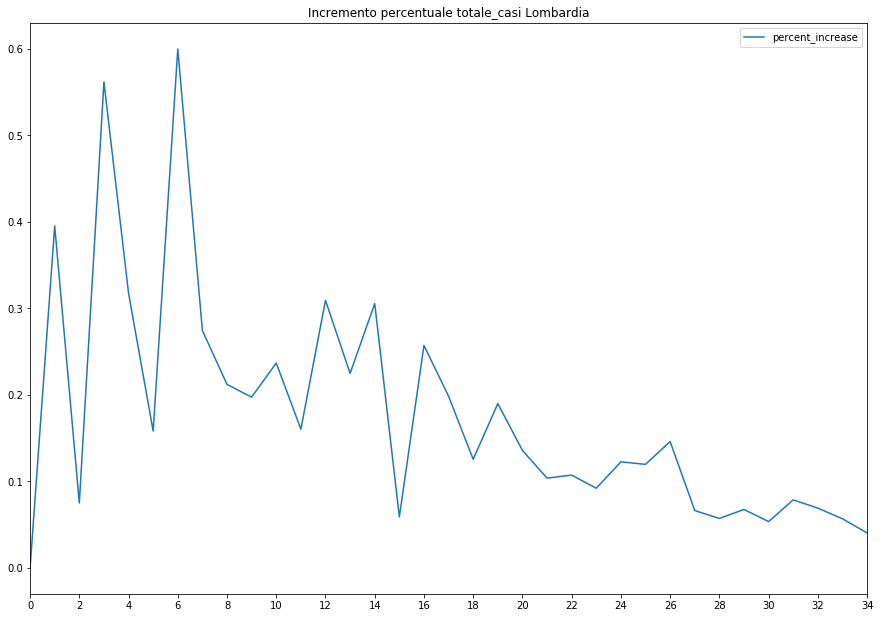

In [116]:
#def compute_perc_increase(df,feature):
#    feat = df[feature].copy()
#    feat=feat.pct_change()
#    increase=pd.DataFrame(data=feat, index=df.index)
#    increase.set_axis(['percent_increase'], axis=1, inplace=True)
#    if not increase.columns.any=='day':
#        increase.insert(0,column='day',value=df['day']) #->non è generale, in alcuni casi day c'è già, quindi dà errore
#    increase.fillna(0,inplace=True)
#    return increase


def compute_increase(df,feature):
    feat = df[feature].copy()
    feat=np.array(feat)
    incr=feat.copy()
    incr[1:]=feat[1:]-feat[:-1]
    increase=pd.DataFrame(data=incr, index=df.index)
    increase.set_axis(['increase'], axis=1, inplace=True)
    if not increase.columns.any=='day':
        increase.insert(0,column='day',value=df['day'])
    return increase



def compute_perc_increase(df_name,feature, where=None):
    if df_name=="province":
        df=get_provincia(where)
    elif df_name=="regioni":
        df=get_regione(where)
    else:
        df=nazione
    increase=pd.DataFrame(data=df[feature].pct_change(), index=df.index)
    increase.set_axis(['percent_increase'], axis=1, inplace=True)
    if not increase.columns.any=='day':
        increase.insert(0,column='day',value=df['day'])
    increase.fillna(0,inplace=True)
    if not np.isfinite(increase['percent_increase']).all():
        aux=increase.loc[increase['percent_increase'] == np.inf]
        to_del=np.arange(aux.iloc[0].name+1)
        increase.drop(to_del, inplace=True)
    #increase.set_index("day", inplace=True)
    
    return increase

#Ho cambiato leggermente per farla funzionare, e poi automaticamente "pulisce" degli 0 e infinito
feature="totale_casi"
where="Lombardia"
inds_X=np.arange(len(nazione))[::2]
compute_perc_increase("regioni",feature, where).plot(figsize=(15,10.5),xticks=inds_X, title="Incremento percentuale " + feature + " " + where)





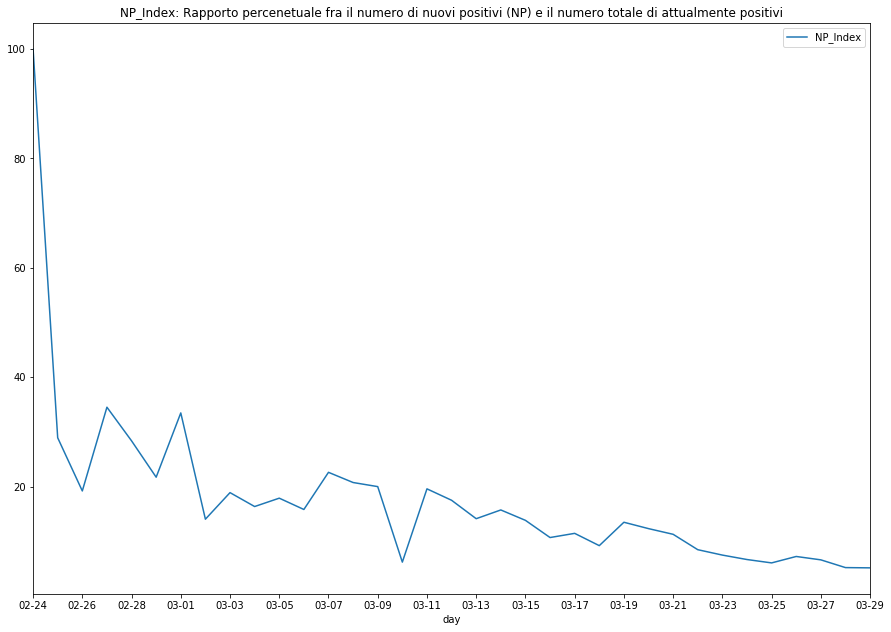

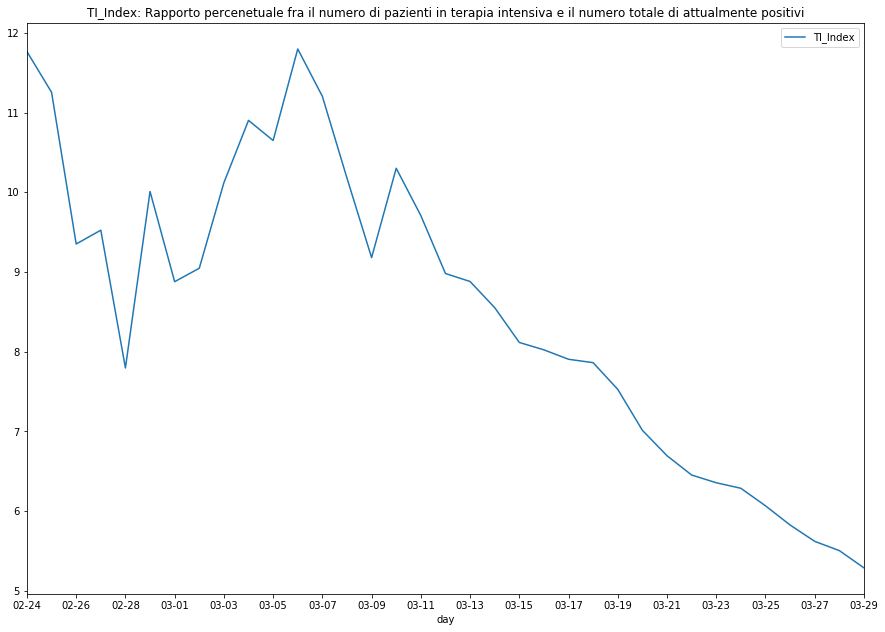

In [17]:
#Indice: rapporto fra il numero di nuovi positivi (NP) e il numero totale di attualmente positivi

ind_NP=pd.DataFrame(data=nazione, columns=["day"])
ind_NP["NP_Index"]=nazione["nuovi_attualmente_positivi"]/nazione["totale_attualmente_positivi"]*100
ind_NP.set_index("day", inplace=True)
inds_X=np.arange(len(ind_NP))[::2]
ind_NP.plot(figsize=(15,10.5), xticks=inds_X, title="NP_Index: Rapporto percenetuale fra il numero di nuovi positivi (NP) e il numero totale di attualmente positivi")


#Indice di terapia intensiva: quanti dei malati vanno in TI?
ind_TI=nazione["terapia_intensiva"]/nazione["totale_attualmente_positivi"]*100
ti=pd.DataFrame(data=ind_TI, columns=["TI_Index"])
ti["day"]=nazione["day"].copy()
ti.set_index("day", inplace=True)
inds_X=np.arange(len(ti))[::2]
ti.plot(figsize=(15,10.5), xticks=inds_X, title="TI_Index: Rapporto percenetuale fra il numero di pazienti in terapia intensiva e il numero totale di attualmente positivi")

# Geographical Plotting attempt

In [22]:
today = date.today()
day=today.strftime("%m-%d")
prov_today=get_giorno(province, day)

prov_today=prov_today.reset_index(drop=True)

inds=np.flatnonzero(prov_today["lat"]==0)
prov_today = prov_today.drop(inds, axis=0)

import matplotlib.image as mpimg
italy_img=mpimg.imread('/Users/admin/Desktop/regions-of-italy-italian-empire-vector-map-png-favpng-HN9ySTV4wneV0n2Wsp0beqddp.jpg')


ax=prov_today.plot(kind='scatter', x="long", y="lat", alpha=0.4,
     s=prov_today["totale_casi"], label="casi", figsize=(15,10.5))
plt.imshow(italy_img,extent=[min(prov_today['long']),max(prov_today['long']),min(prov_today['lat']),max(prov_today['lat'])],alpha=0.7, cmap=plt.get_cmap("jet"))
plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.legend(fontsize=14,loc='best')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/admin/Desktop/regions-of-italy-italian-empire-vector-map-png-favpng-HN9ySTV4wneV0n2Wsp0beqddp.jpg'

With the above functions we can analyze the province of Pisa for example

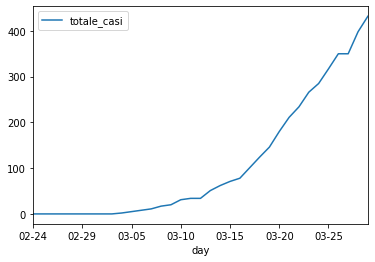

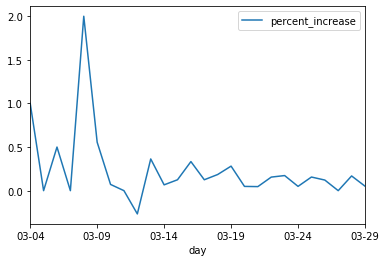

In [18]:
pisa=get_provincia("Pisa",province)
pisa.set_index("day", inplace=True)
pisa.plot()
increase=compute_perc_increase("province","totale_casi", "Cagliari")
increase.plot()

Since we will need a lot of plotting, we now define a function to plot any two variables from the dataframe

In [58]:
def plot_df(df,asc,ords,kind='line'):
    plt.clf()
    if asc=='day':
        inds_x=np.arange(len(df))[::2]
        inds_y=np.linspace(min(df[ords]),max(df[ords]),num=20)
    else:
        inds_x=np.linspace(min(df[asc]),max(df[asc]),num=20)
        inds_y=np.linspace(min(df[ords]),max(df[ords]),num=20)
        
    ax=df.plot(x=asc,y=ords,label=ords+' over '+asc,figsize=(15,10.5),xticks=inds_x,yticks=inds_y,kind=kind)
    
    plt.xlabel(asc,fontsize=14)
    plt.ylabel(ords,fontsize=14)
    plt.legend(fontsize=14,loc='best')
    plt.show()

def multi_plot_df(dlist,asc,ords,names=None,kind='line'):
    plt.clf()
    if names==None:
        names=[str(i+1) for i in range(len(dlist))] 
    if asc=='day':
        inds_x=np.arange(len(dlist[0][asc]))[::2]
    ax=dlist[0].plot(x=asc,y=ords,label=names[0],figsize=(15,10.5),kind=kind)
    dlist.remove(dlist[0])
    names.remove(names[0])
    for df in dlist:
        df.plot(ax=ax,x=asc,y=ords,label=names[dlist.index(df)],figsize=(15,10.5),kind=kind)
    
    plt.title(ords+' over '+asc,fontsize=20)
    plt.xlabel(asc,fontsize=14)
    plt.ylabel(ords,fontsize=14)
    plt.legend(fontsize=14,loc='best')
    plt.show()

<Figure size 432x288 with 0 Axes>

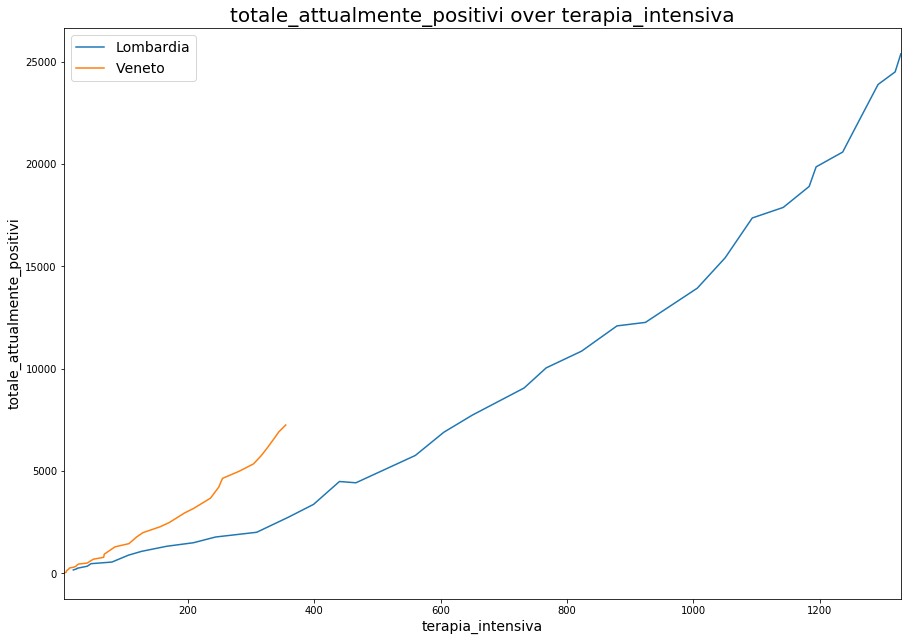

In [20]:
Lom=get_regione('Lombardia',regioni)
Ven=get_regione('Veneto',regioni)
multi_plot_df([Lom,Ven],'terapia_intensiva','totale_attualmente_positivi', names=['Lombardia','Veneto'])



<Figure size 432x288 with 0 Axes>

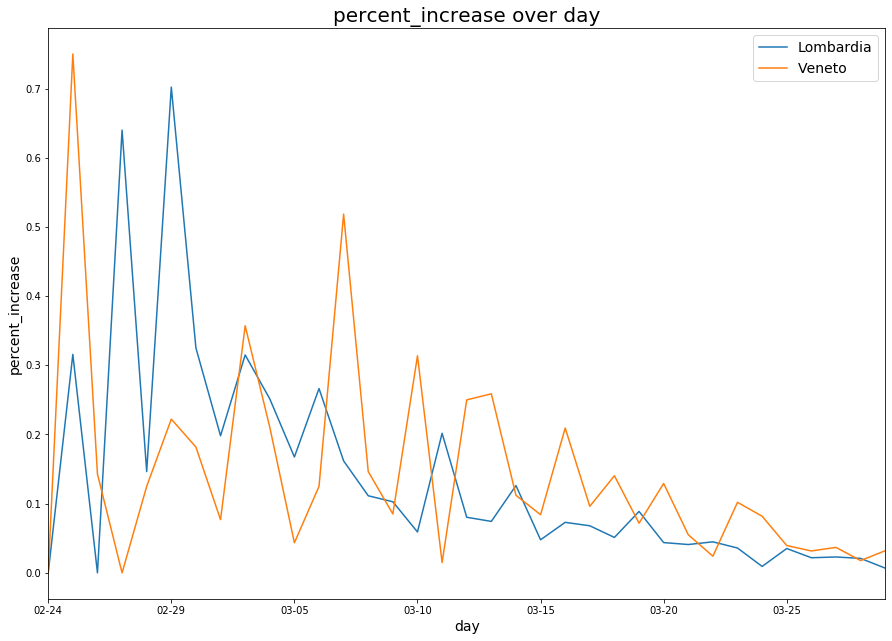

In [24]:
multi_plot_df([compute_perc_increase("regioni",'terapia_intensiva', "Lombardia"),compute_perc_increase("regioni", "terapia_intensiva", "Veneto")],
              'day','percent_increase',names=['Lombardia','Veneto'])

In [42]:
Lom=get_regione("Lombardia",regioni)
tamp_day=compute_increase(Lom,'tamponi')
tamp_day.tail()

,day,increase
30,03-25,4971
31,03-26,6047
32,03-27,8147
33,03-28,6643
34,03-29,4895


In [62]:
#tamp_day=compute_perc_increase("nazione",'tamponi')
tamp_day=compute_perc_increase("regioni",'tamponi', "Lombardia")
tamp_day.tail()

,day,percent_increase
30,03-25,0.064815
31,03-26,0.074046
32,03-27,0.092882
33,03-28,0.069299
34,03-29,0.047755


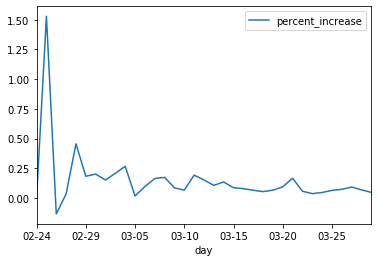

In [66]:
tamp_day.set_index("day", inplace=True)
tamp_day.plot()

#plot_df(tamp_day,'day','percent_increase',kind='scatter')
#scatter requires x column to be numeric
#PORCODIO PERCHE' A TE CON COMPUTE_INCREASE NON DAVA ERRORE

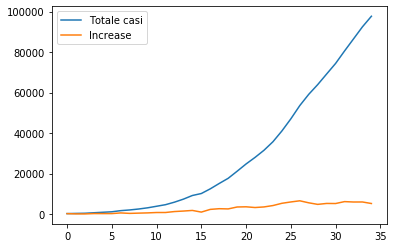

In [119]:
tot=plt.plot(nazione["totale_casi"], label="Totale casi")
#incr=plt.plot(compute_perc_increase("nazione", "totale_casi")["percent_increase"], label="Percent Increase")
incr=plt.plot(compute_increase(nazione, "totale_casi")["increase"], label="Increase")
plt.legend()

# Approximation attempt

we now try to approximate the function to a polynomial or to a logistic function in the first case we also have to assess the correct grade of the polynomial

In [67]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from sklearn.pipeline import Pipeline

In [94]:
def plot_learning_curves(model,X,y):
    X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2)
    train_err,val_err=[],[]
    for i in range(1,len(X_train)):
        model.fit(X_train[:i],y_train[:i])
        y_train_pred=model.predict(X_train[:i])
        y_val_pred=model.predict(X_val)
        train_err.append(mean_squared_error(y_train[:i],y_train_pred[:i]))
        val_err.append(mean_squared_error(y_val[:i],y_val_pred[:i]))
    plt.figure(figsize=(20,20))
    plt.plot(np.sqrt(train_err),'r-+',linewidth=2,label='train')
    plt.plot(np.sqrt(val_err),'b-',linewidth=2,label='validation')
    plt.legend(fontsize="xx-large")
    print('The training error is: ',np.sqrt(train_err[-1]))
    print('The validation error is: ',np.sqrt(val_err[-1]))    

this is a second degree polynomial approximation, we will later implement it in a pipeline to try to get the best degree approximation

Below a way of plotting approximation vs real data for a second degree polynomial (TO GENERALIZE)

/Users/rob/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<Figure size 432x288 with 0 Axes>

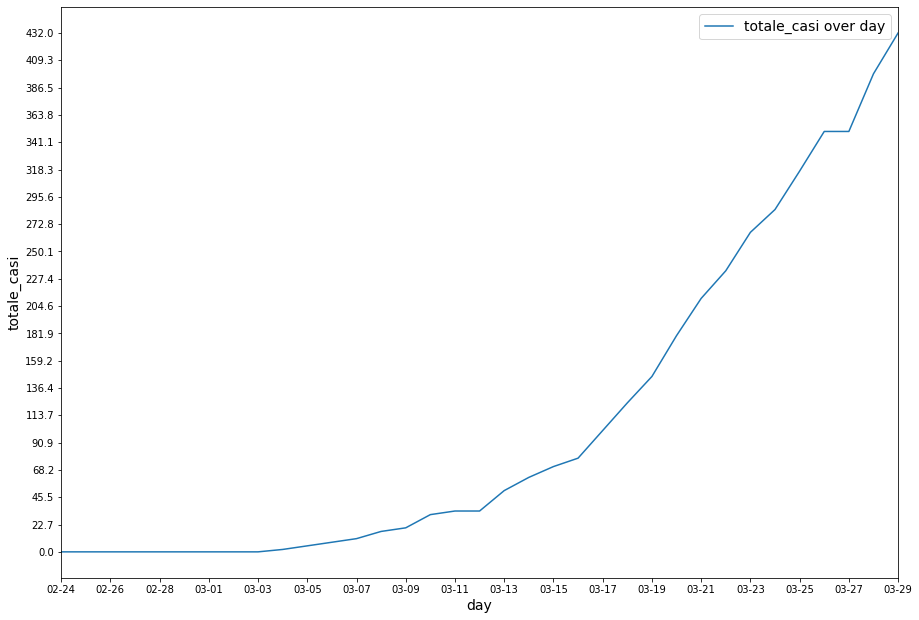

[]

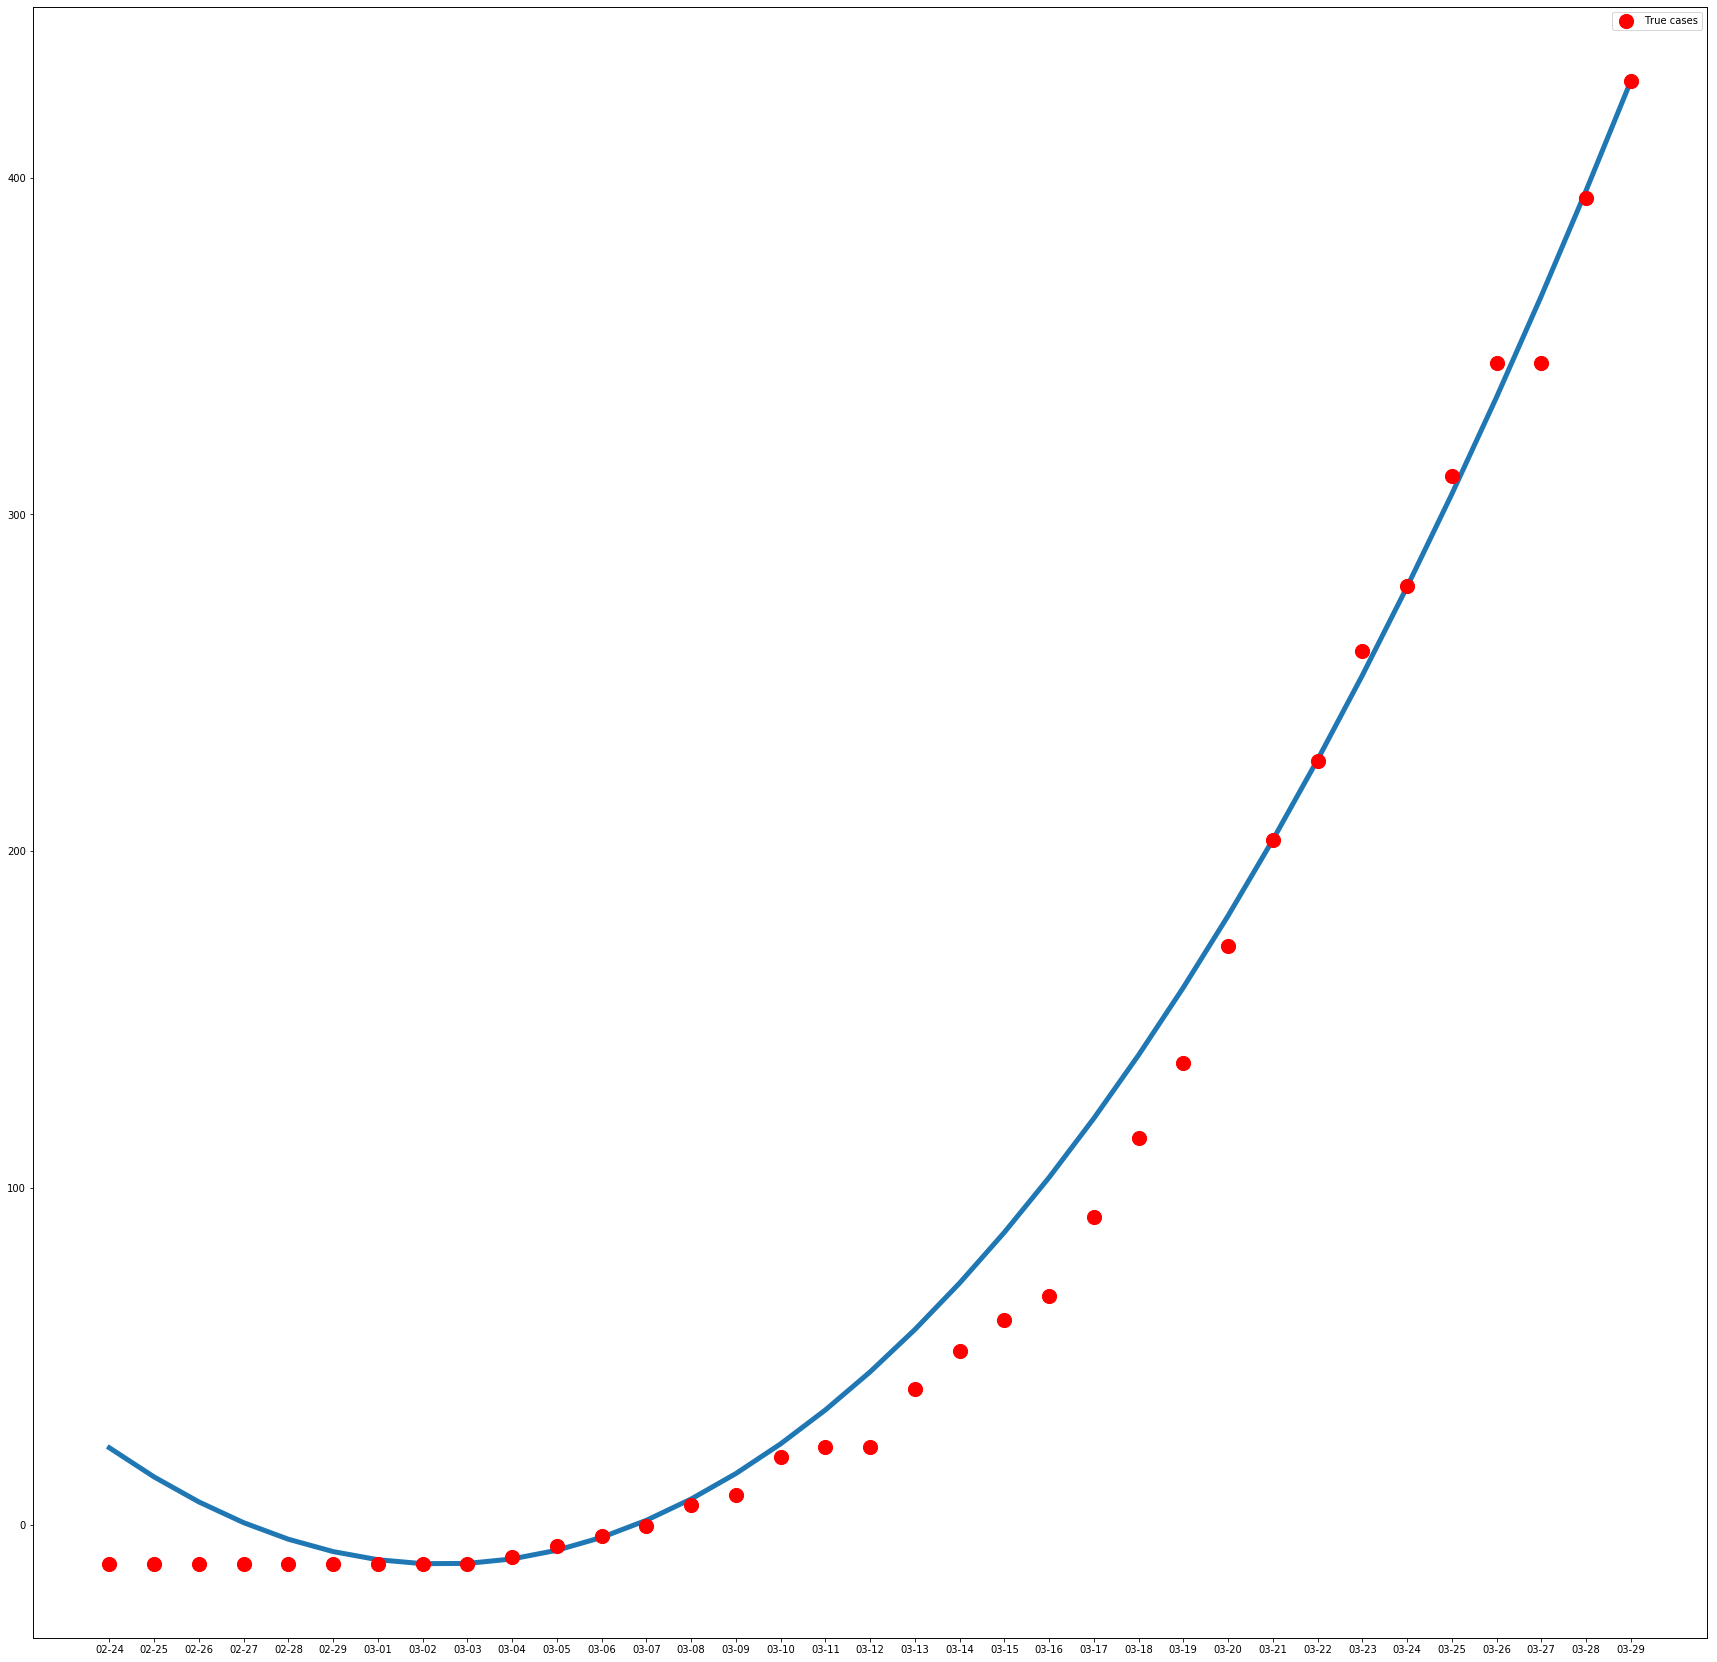

In [69]:
pisa=get_provincia('Pisa',province)
plot_df(pisa,'day','totale_casi')
p=PolynomialFeatures(degree=2,include_bias=False)
y=pisa['totale_casi']
X=np.arange(0,len(y)).reshape(-1,1)
X_pol=p.fit_transform(X)
lr=LinearRegression()
lr.fit(X_pol,y)
fig=plt.figure(figsize=(30,30))
ax1=fig.add_subplot(111)
ax2=ax1.twinx()
ax2.scatter(pisa['day'],pisa['totale_casi'],c='r',label='True cases',s=200)
#x=np.arange(0,n_obs)
#fun=lr.coef_[0]*x+lr.coef_[1]*x**2+lr.intercept_
ax1.plot(lr.predict(X_pol),label='approximation',linewidth=5)
plt.legend(loc='best')
ax2.set_yticks([])
#ax2.set_xticks([])


##problems###
#mettere a posto legenda fa cagare

    
    
##problems##
#i dati vanno standardizzati, non credo l'object lo fccia da solo
#o magari si
    
    
    
##problemi##
#perchè non esce il label di approximation ma il plot si? diocane
#dobbiamo generalizzare sennò è un casino rifare il plot per un grado 10 hahahhaha
#confido nelle tue capacità di indexing


In [70]:
def plot_approx(area,asc,ords,degree=2):
    p=PolynomialFeatures(degree=degree,include_bias=False)
    y=area[ords]
    if asc=='day':
        X=np.arange(0,len(y)).reshape(-1,1)
    else:
        X=area[asc].to_numpy().reshape(-1,1)
    X_pol=p.fit_transform(X)
    lr=LinearRegression()
    lr.fit(X_pol,y)
    plt.clf()
    fig=plt.figure(figsize=(30,30))
    ax1=fig.add_subplot(111)
    ax2=ax1.twinx()
    ax2.scatter(area[asc],area[ords],c='r',label='True values',s=200)
    ax1.plot(X,lr.predict(X_pol),label='approximation',linewidth=5)
    plt.legend(loc='best')
    ax2.set_yticks([])

The training error is:  54.520467639045116
The validation error is:  74.90912316174635


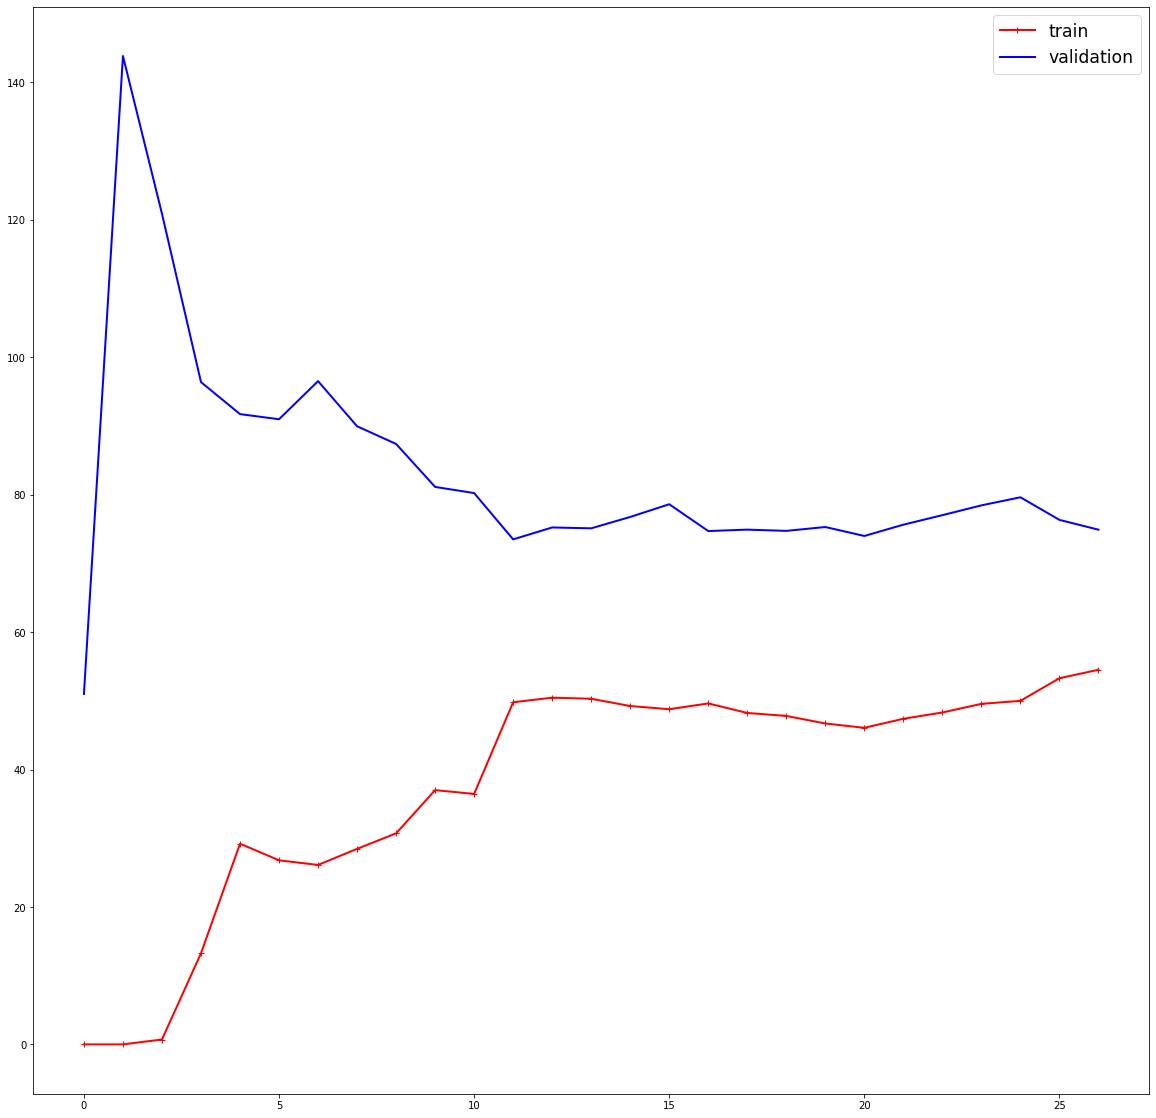

In [95]:
plot_learning_curves(lr,X,y)

##problems##
#sarebbe carino zoommare il plot per capire a che errore si stabilizza
#se impossibile almeno stampare l'errore finale
#runnandolo più volte l'errore è molto random, probabilmente perchè c'è overfitting o 
#semplicemente perchè ci sono pochi dati a disposizione, una soluzione si incontrerebbe
#facendo regression su più dati, questa è una prova su pisa a caso


Now we will try to check which is the best degree for approximating these data

The training error is:  3526.787029273735
The validation error is:  5435.320662410858
The training error is:  309.5096007473826
The validation error is:  381.5140927252581
The training error is:  292.72017470460406
The validation error is:  396.2556850947606


<Figure size 432x288 with 0 Axes>

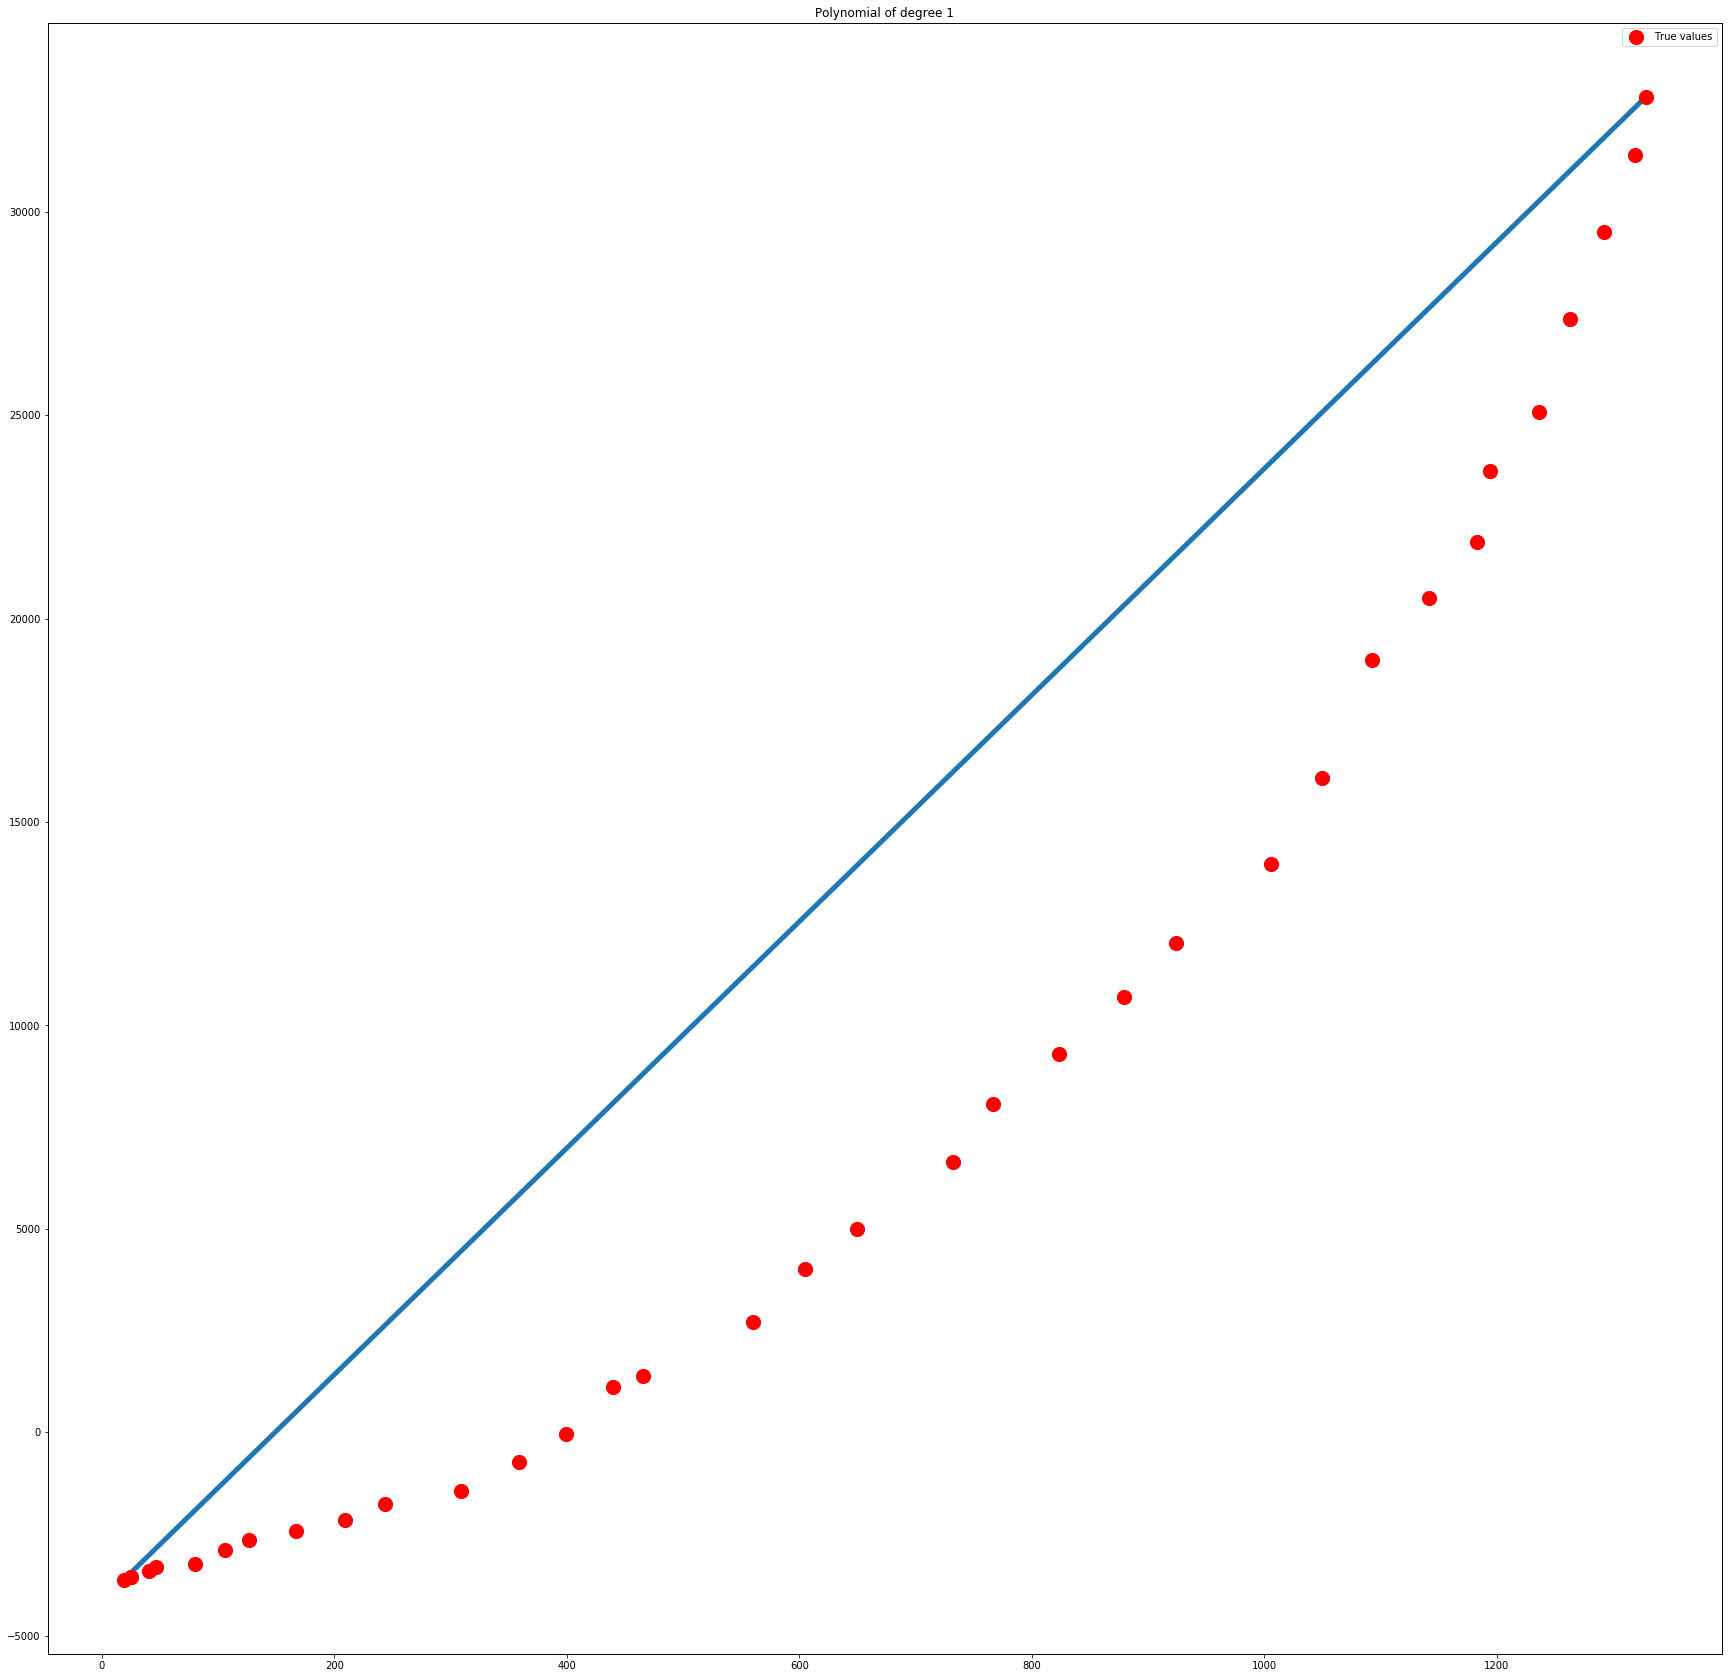

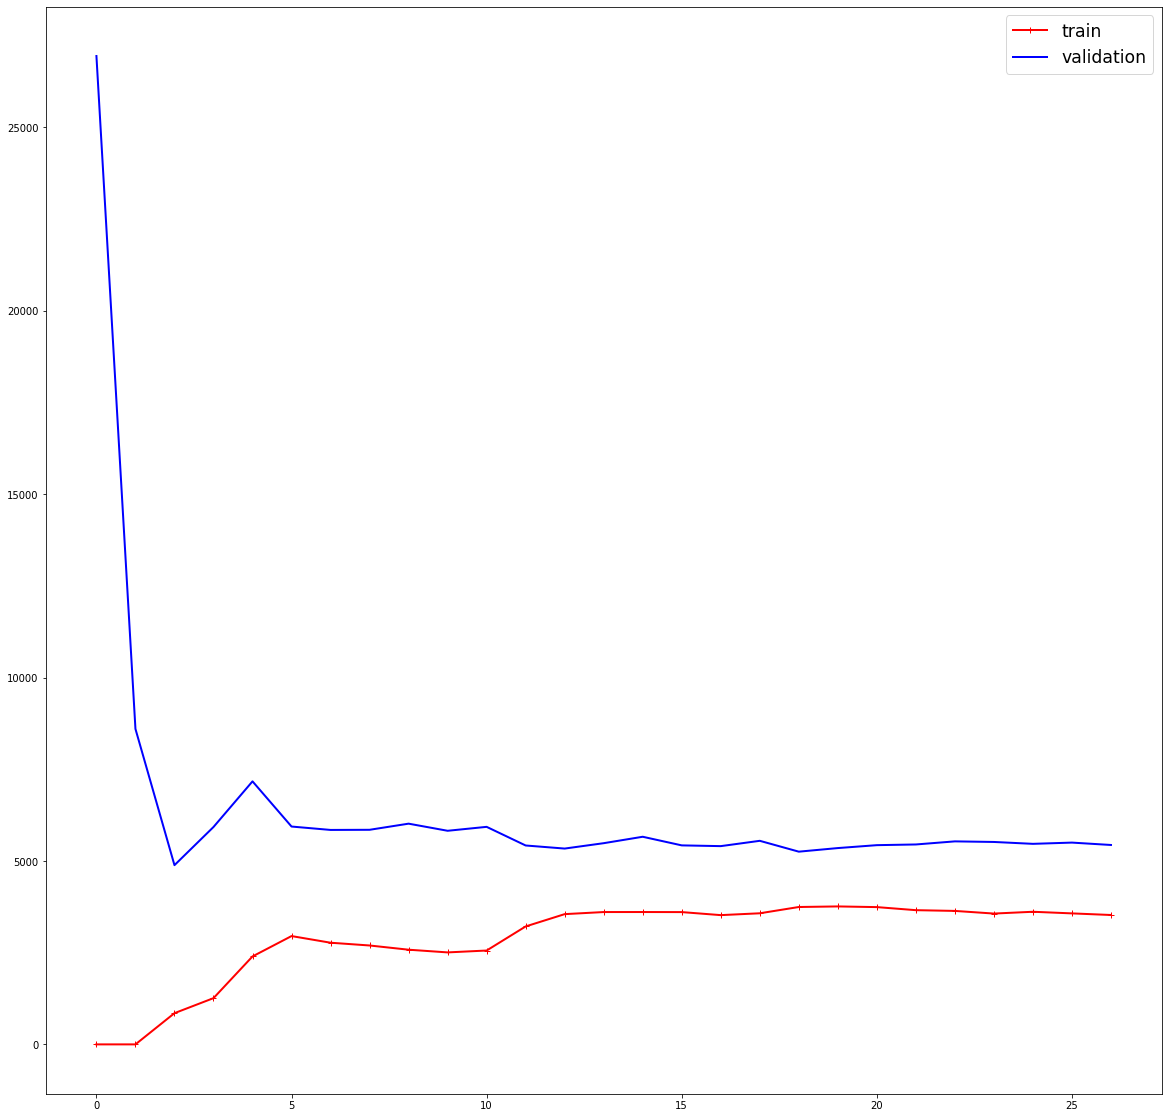

<Figure size 432x288 with 0 Axes>

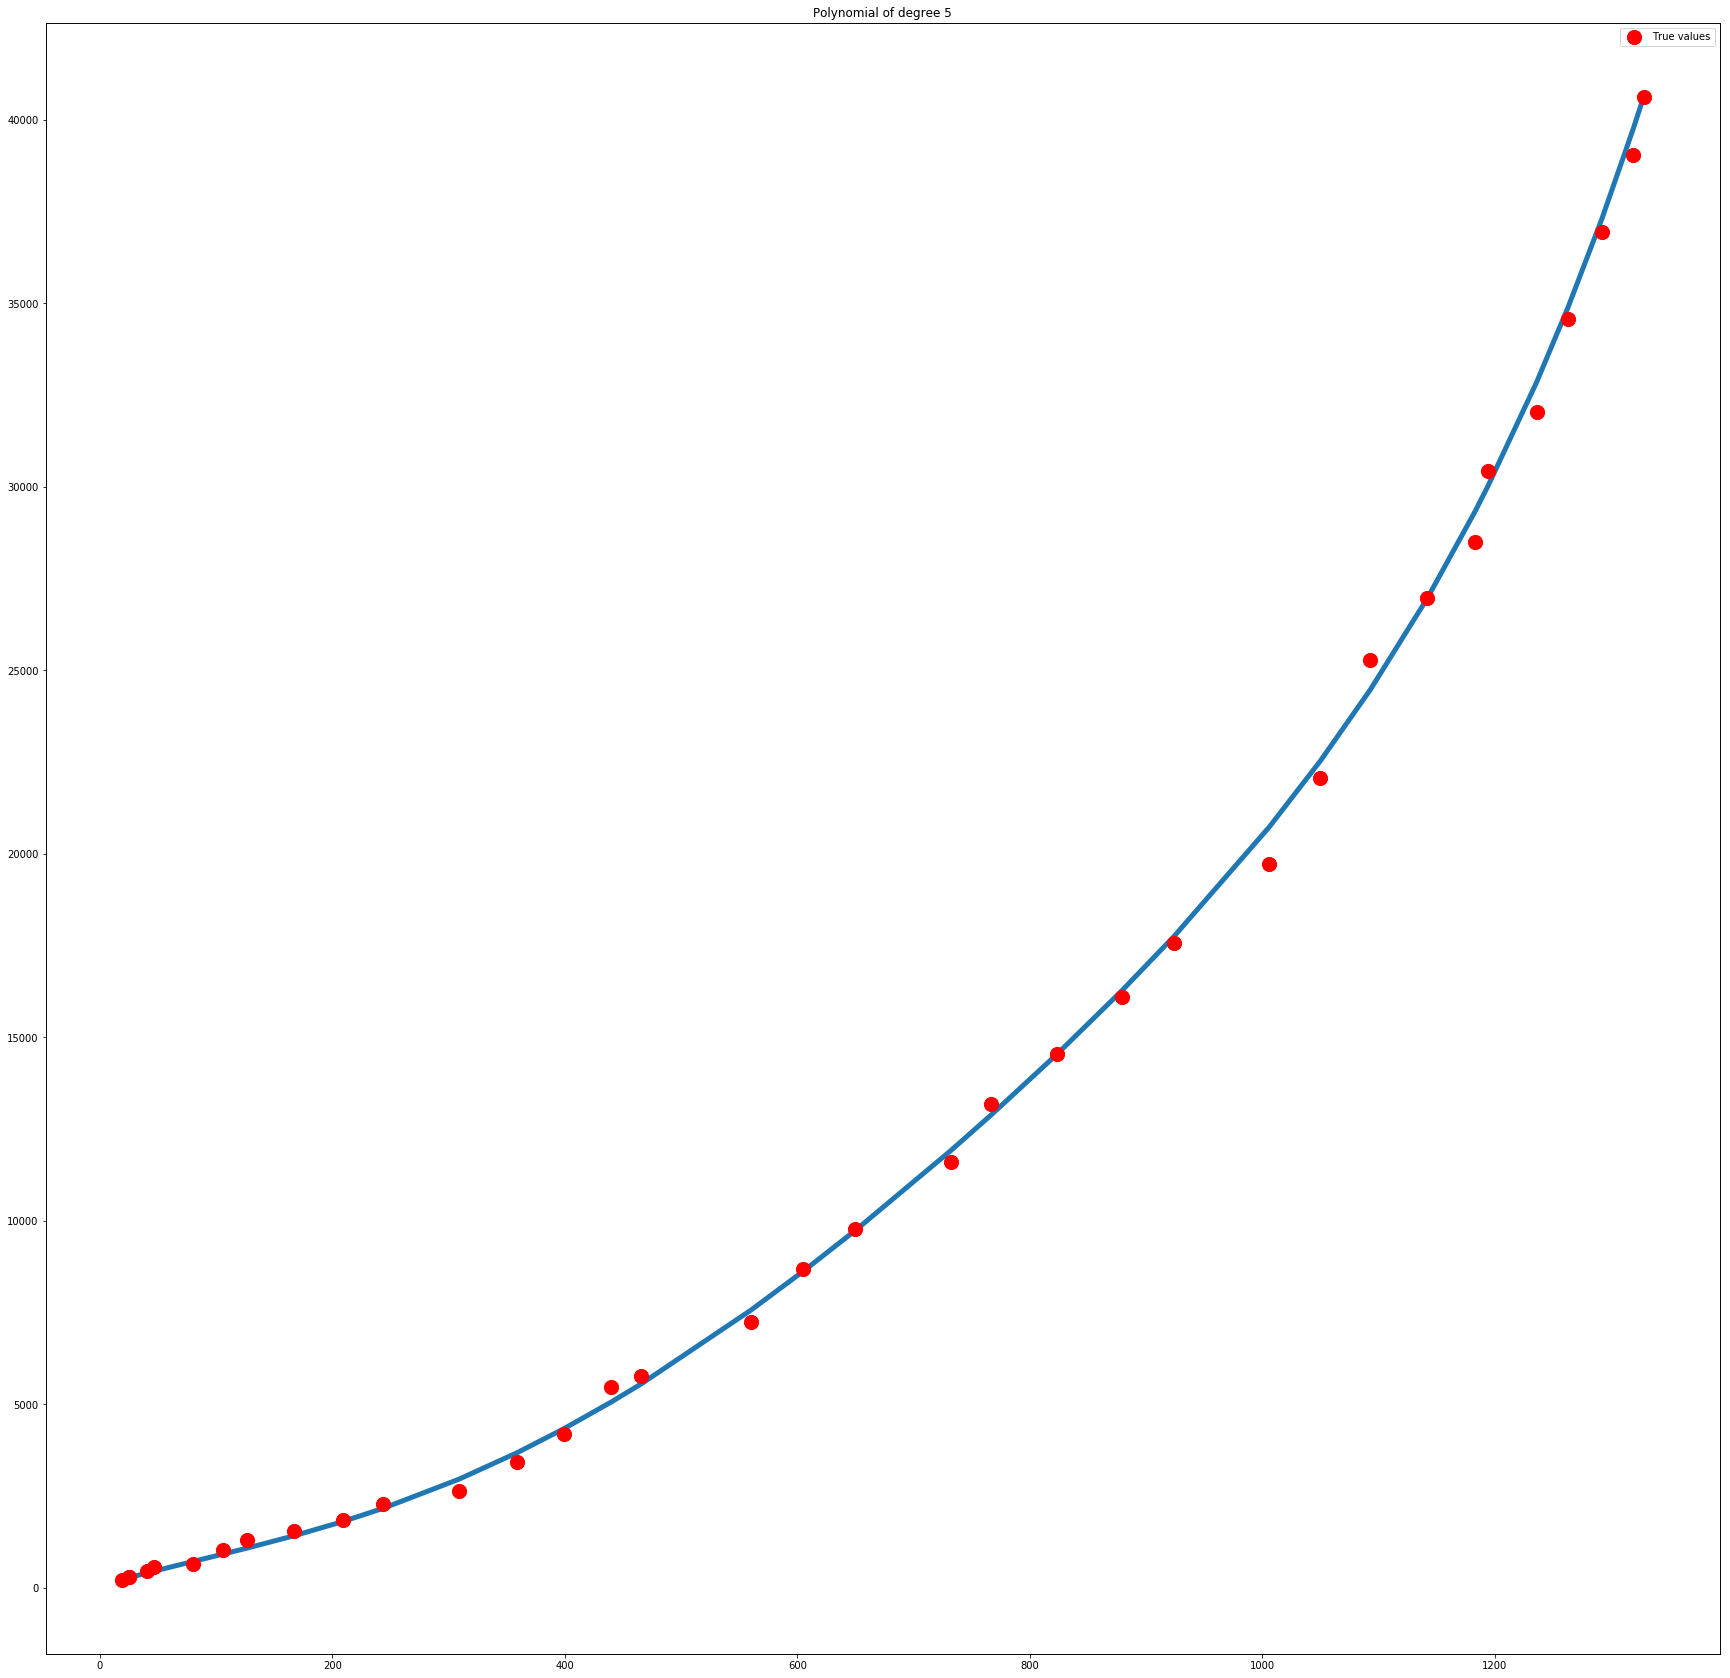

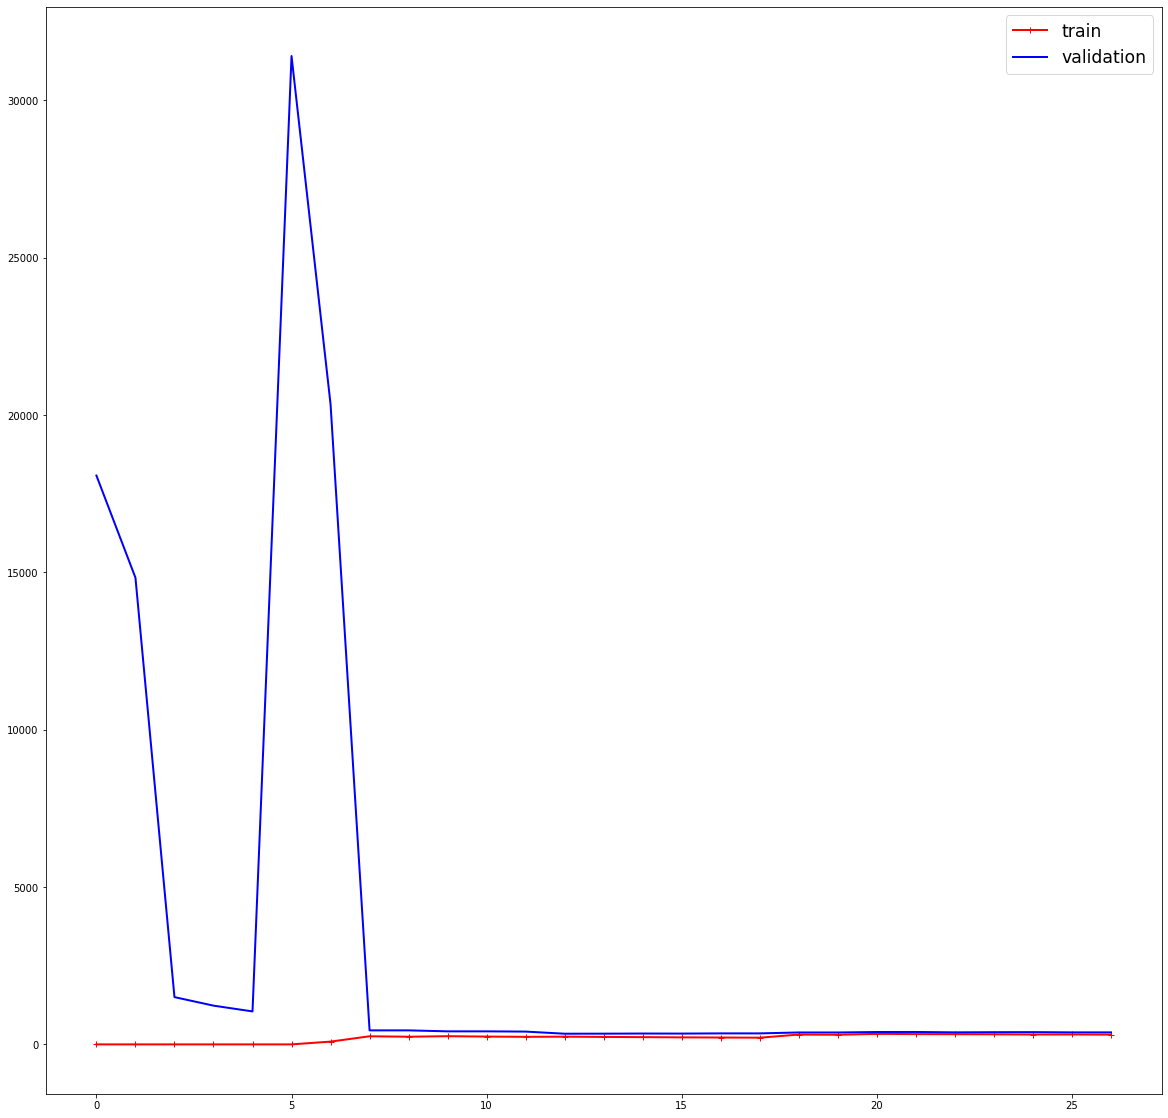

<Figure size 432x288 with 0 Axes>

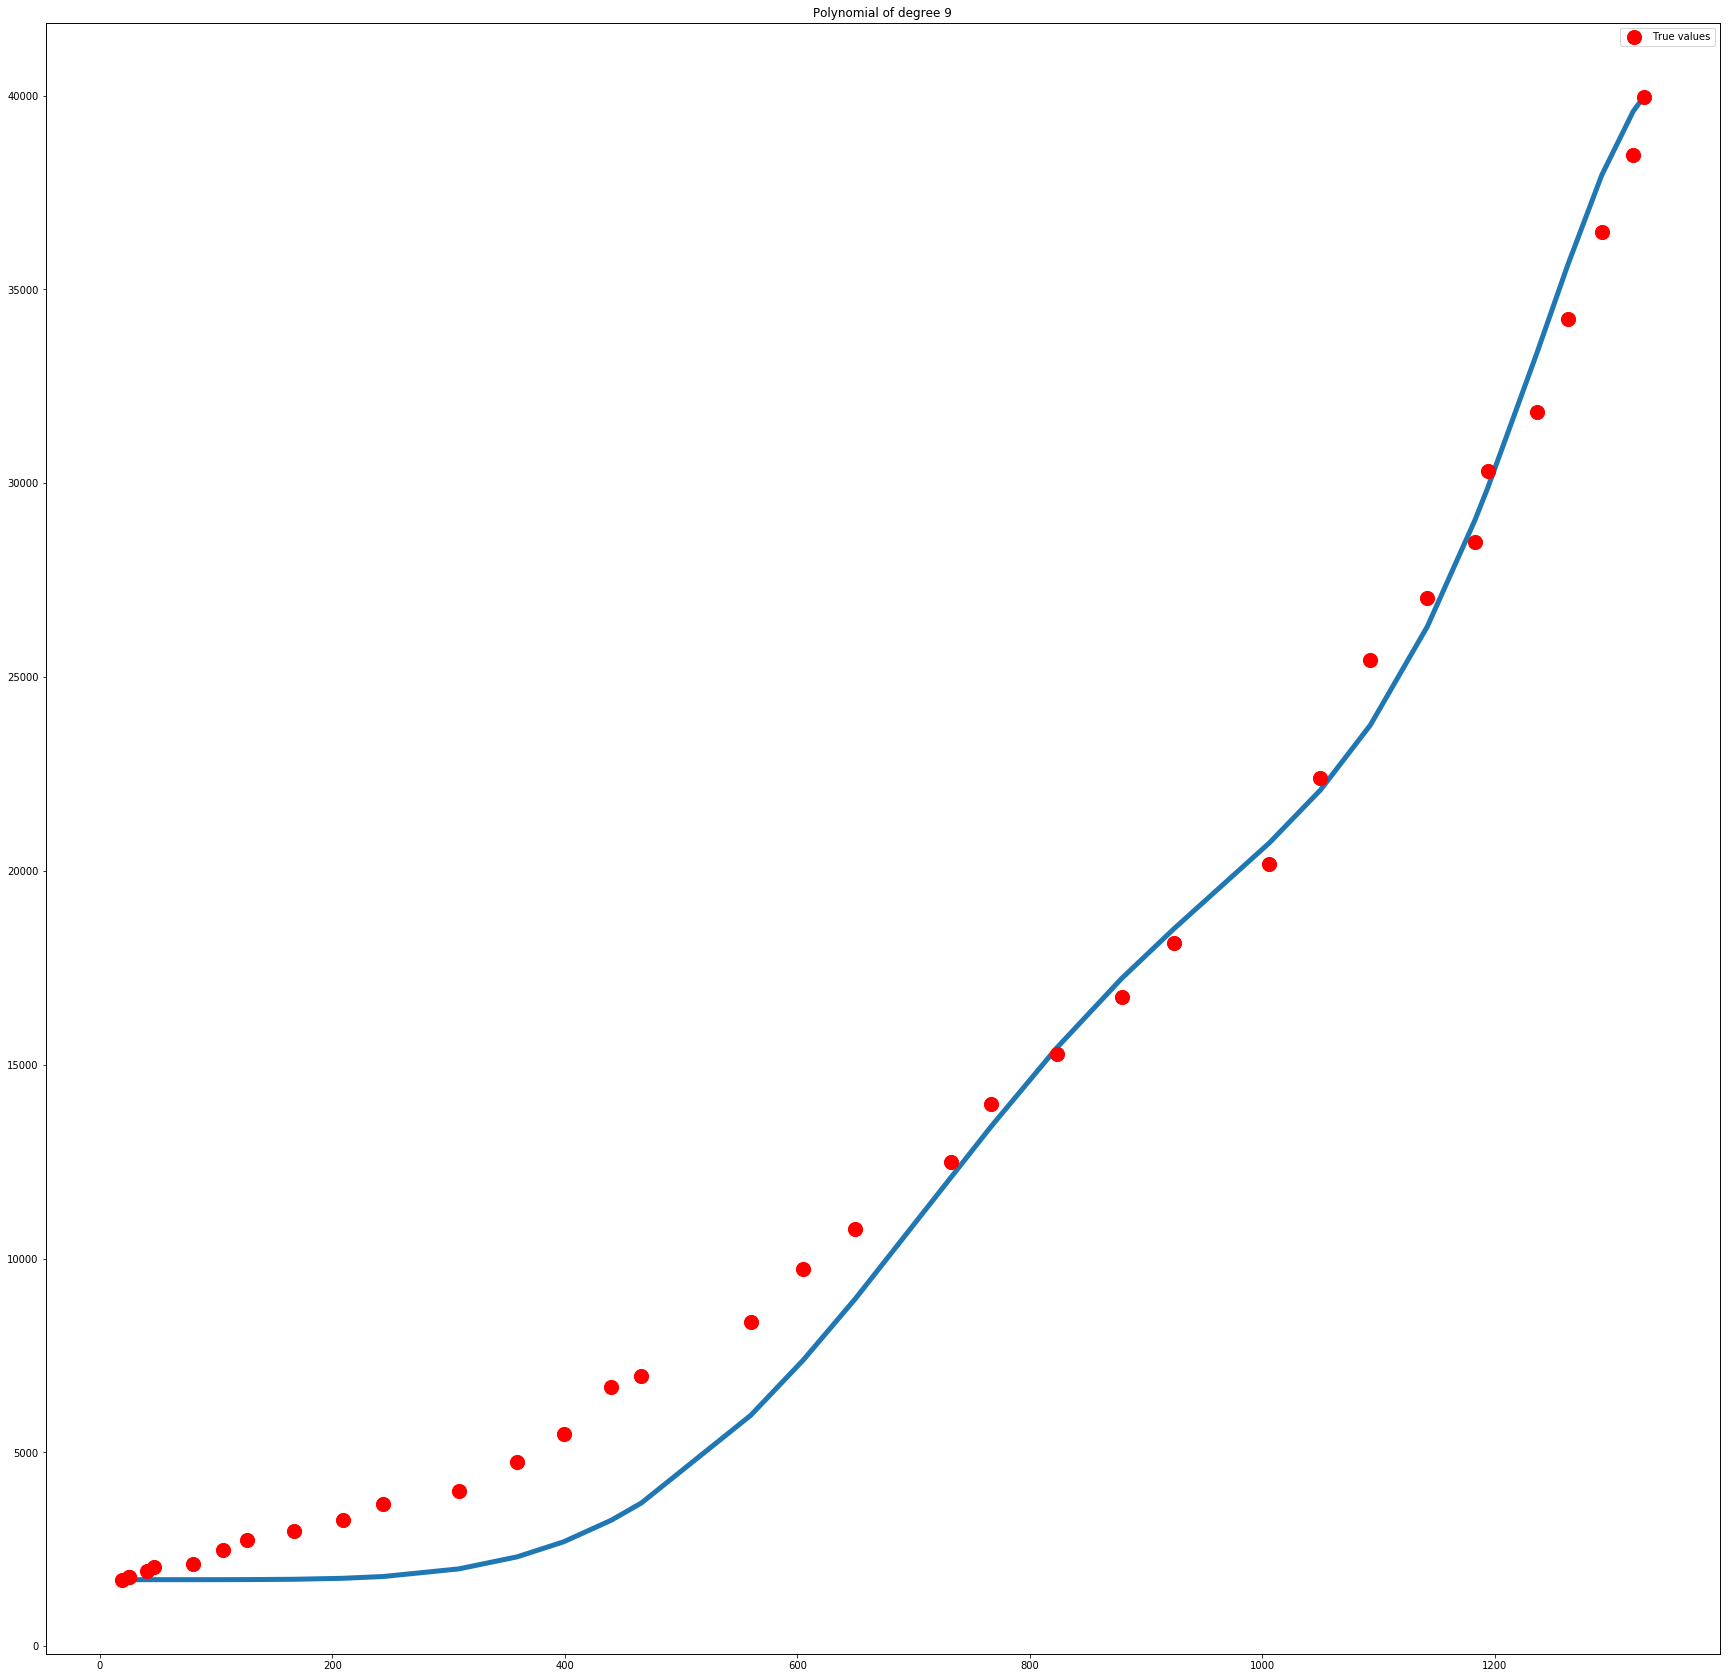

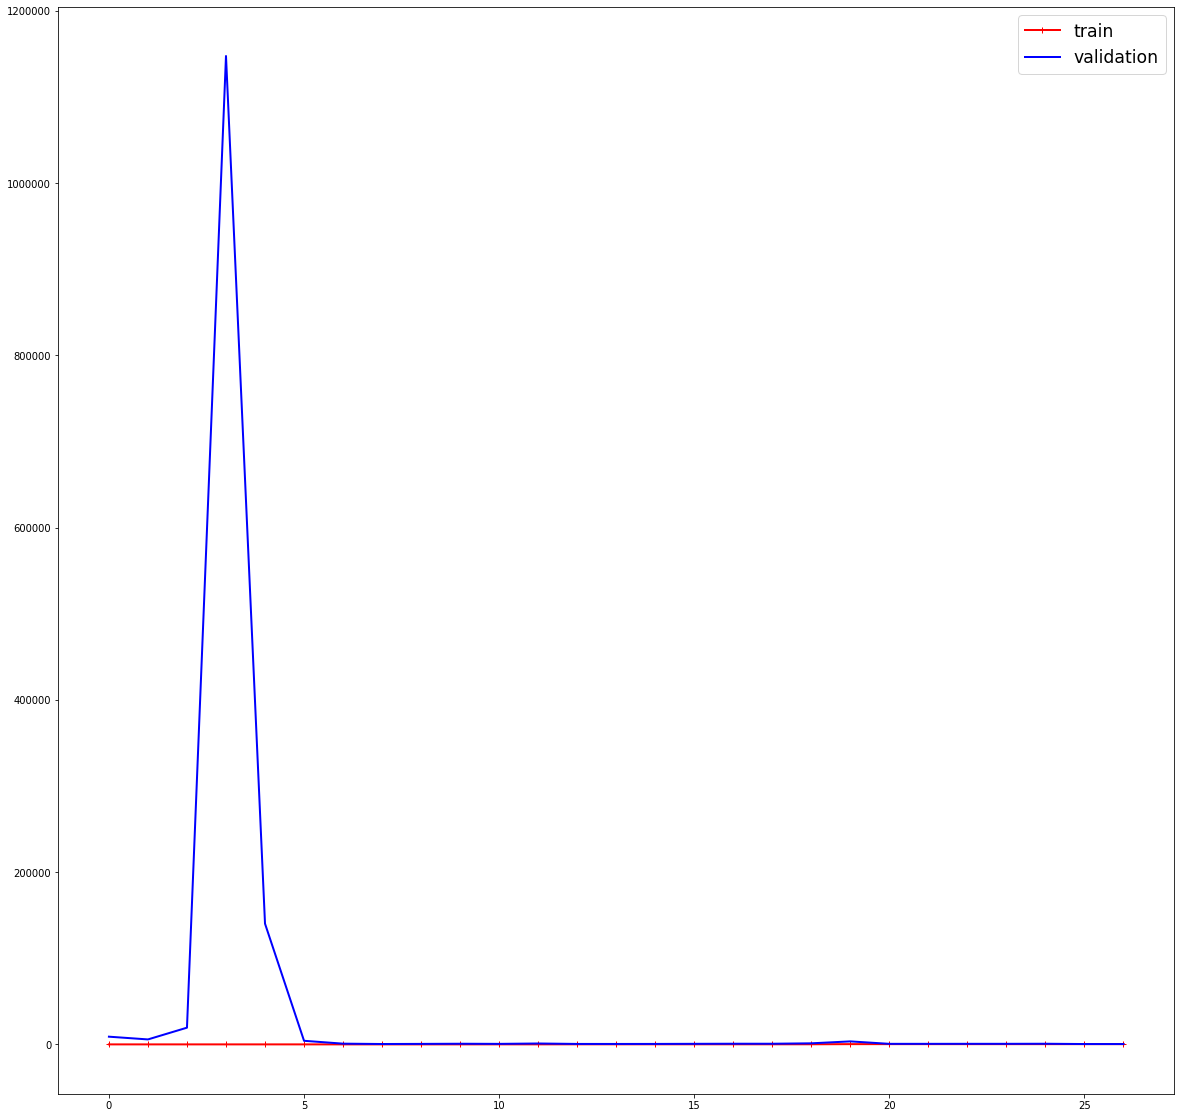

In [105]:
for i in range(10):
    pol_reg=Pipeline([('p',PolynomialFeatures(degree=i,include_bias=False)),('lr',LinearRegression())])
    if i==1 or i==5 or i==9:
        plt.figure()
        plot_approx(Lom,'terapia_intensiva','totale_casi',degree=i)
        plt.title(f'Polynomial of degree {i}')
        plot_learning_curves(pol_reg,X,y)
#SEMBRA FUNZIONARE MA NON E' CORRETTO, X AND y NON C'ENTRANO

up next:


    1. problemi vari da risolvere
    4. find database inquinamento
    2. a link I found for data fitting: https://lmfit.github.io/lmfit-py/model.html
     che figo, tabulando viene colorato
    3.generalizzazione
    5. a posto geoplot (fa cagare) - Ho sbattuto la testa contro Basemap ma è un bordello da installare
    7. plottare totale positivi sulle x e incrementi sulle y (anche con tamponi) - MEH
    8. check magic commands
    9.https://stackoverflow.com/questions/31984196/ipython-notebook-run-all-cells-on-open
    è un link per capire come runnare le celle all'apertura che però a quanto pare non si può boh 
    
    

the following is an attempt to plot the approximation versus reality graph of a some data

<Figure size 432x288 with 0 Axes>

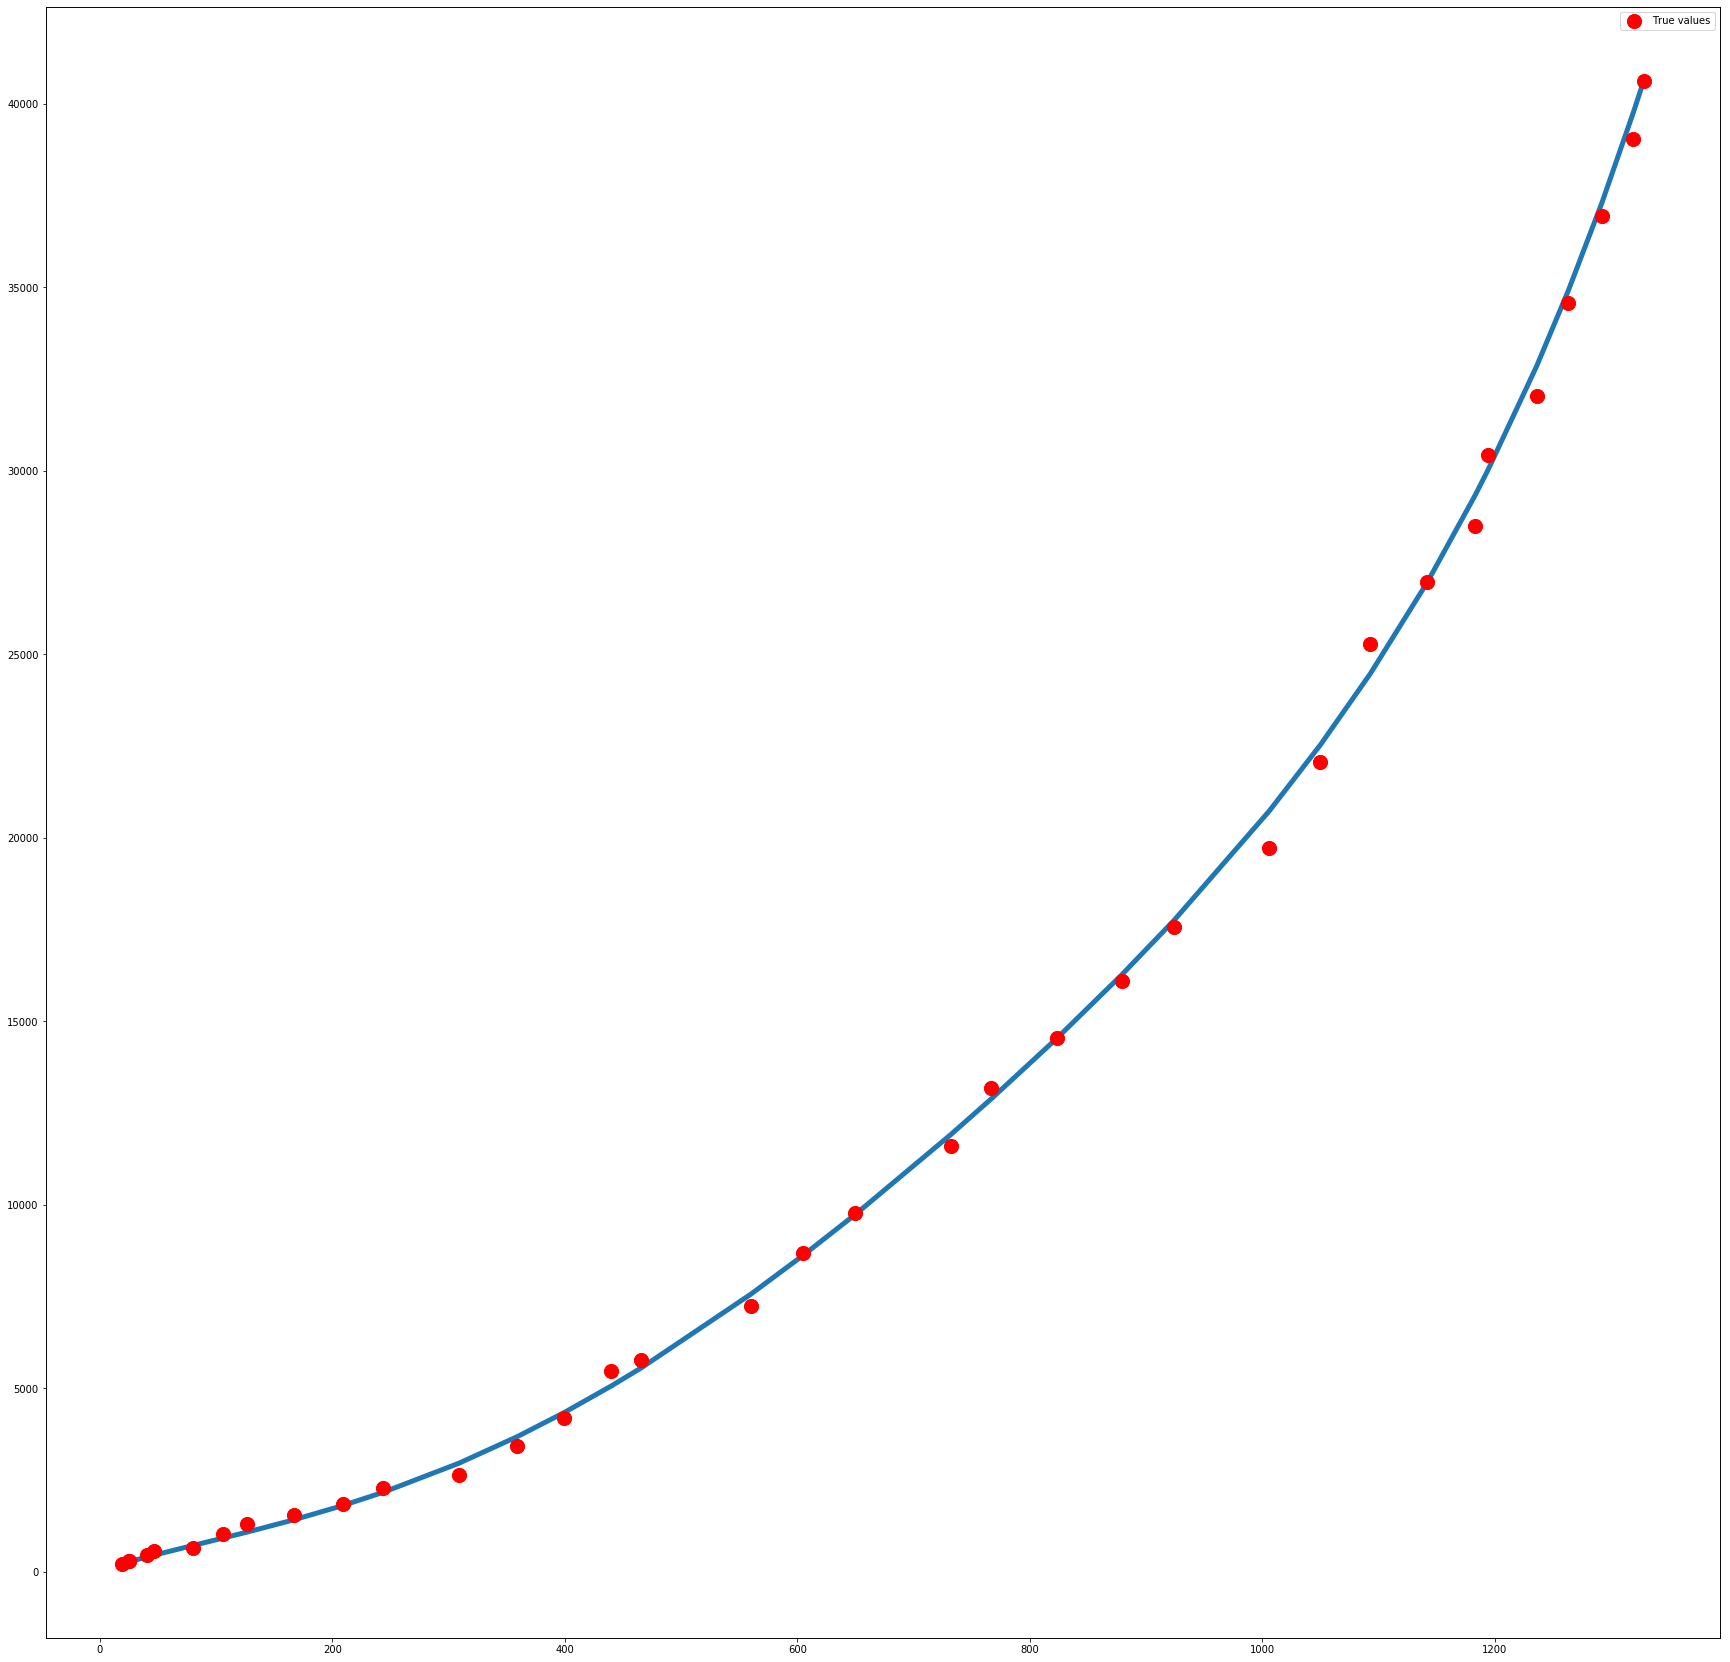

In [97]:
plot_approx(Lom,'terapia_intensiva','totale_casi',degree=5)

In [98]:
def plot_approx(area,asc,ords,degree=2):
    p=PolynomialFeatures(degree=degree,include_bias=False)
    y=area[ords]
    if asc=='day':
        X=np.arange(0,len(y)).reshape(-1,1)
    else:
        X=area[asc].to_numpy().reshape(-1,1)
    X_pol=p.fit_transform(X)
    lr=LinearRegression()
    lr.fit(X_pol,y)
    plt.clf()
    fig=plt.figure(figsize=(30,30))
    ax1=fig.add_subplot(111)
    ax2=ax1.twinx()
    ax2.scatter(area[asc],area[ords],c='r',label='True values',s=200)
    ax1.plot(X,lr.predict(X_pol),label='approximation',linewidth=5)
    plt.legend(loc='best')
    ax2.set_yticks([])


[]

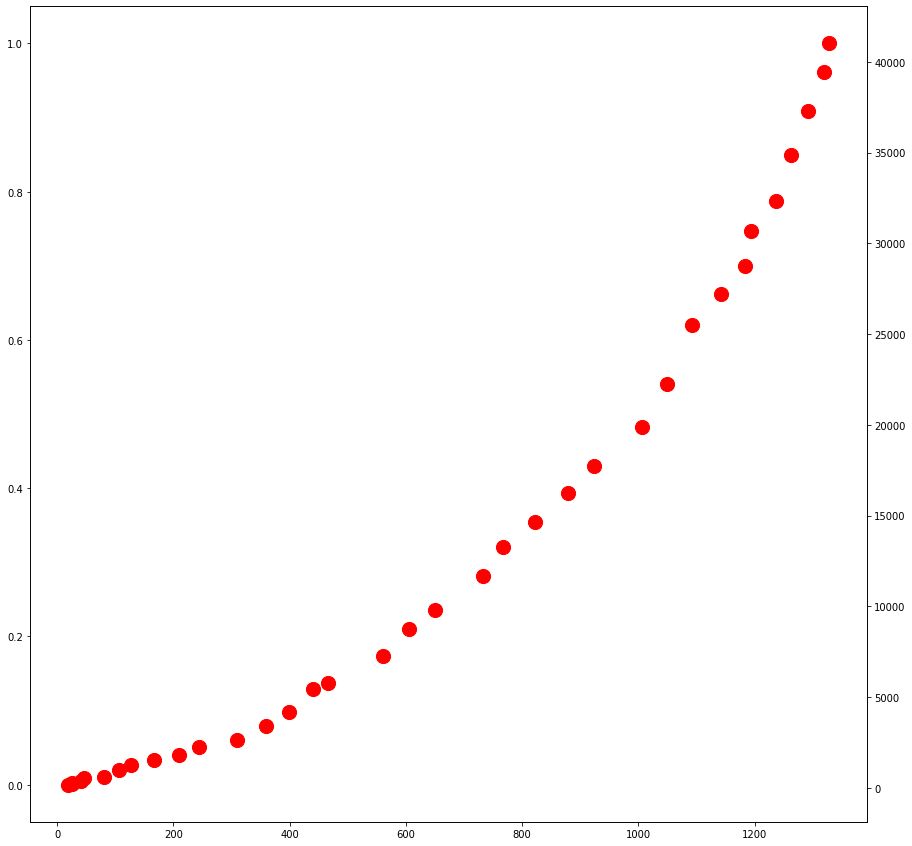

In [99]:
#####QUA DEVO FINIRE########


p=PolynomialFeatures(degree=3,include_bias=False)
x=Lom['terapia_intensiva'].to_numpy().reshape(-1,1)
y=Lom['totale_casi']
x_pol=p.fit_transform(x)
lr=LinearRegression()
lr.fit(x_pol,y)
fig=plt.figure(figsize=(15,15))
ax1=fig.add_subplot(111)
ax2=ax1.twinx()
ax2.scatter(Lom['terapia_intensiva'],Lom['totale_casi'],c='r',label='True values',s=200)
ax1.plot()


In [ ]:
Lom['terapia_intensiva']